In [1]:
import pandas as pd
import numpy as np







Batch KMeans ARI: 0.961
Online Improved ARI: 0.944


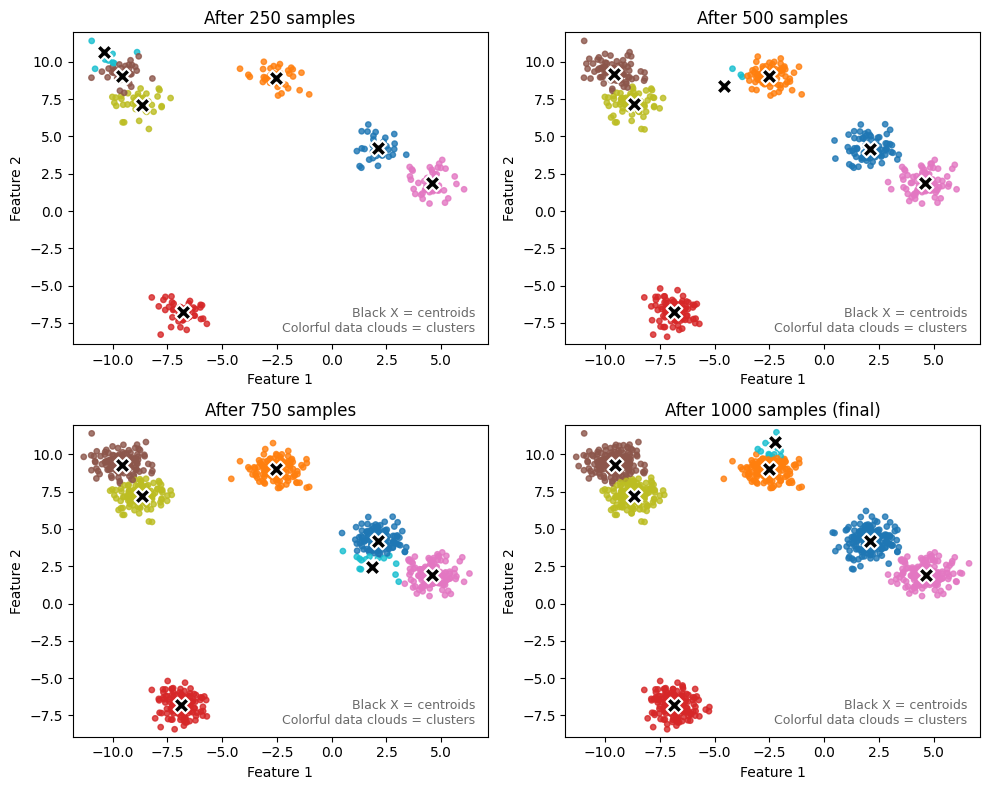

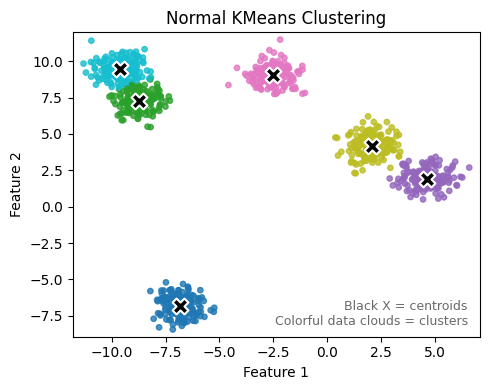

In [2]:
# ---- Generate data ----
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

from OnlineKMeans import OnlineKMeans


X, y_true = make_blobs(
    n_samples=1000, centers=6, cluster_std=0.64,
    random_state=42, n_features=2
)

# ---- Batch KMeans reference ----
kmeans_batch = KMeans(n_clusters=6, random_state=42, n_init=10).fit(X)
y_batch = kmeans_batch.labels_

# ---- Online KMeans Improved (your implementation) ----
online = OnlineKMeans(
    n_clusters=4,
    max_clusters=10,
    metric="euclidean",
    new_cluster_threshold=2.0, # 2.0
    merge_threshold=1.7, #1.7
    random_state=42,
)

# ---- Stream simulation ----
batch_size = 25
snapshots = []

# exact quarter checkpoints for 1000 samples
checkpoints = [250, 500, 750, 1000]
captured = set()
samples_seen = 0

for i in range(0, len(X), batch_size):
    batch = X[i : i + batch_size]
    online.partial_fit(batch)
    samples_seen += len(batch)

    # capture snapshot when we reach or pass a checkpoint
    for cp in checkpoints:
        if samples_seen >= cp and cp not in captured:
            labels_now = online.predict(X)
            snapshots.append((cp, np.copy(online.centroids), labels_now))
            captured.add(cp)

# ---- Evaluate ----
_, _, labels_final = snapshots[-1]
ari_batch = adjusted_rand_score(y_true, y_batch)
ari_online = adjusted_rand_score(y_true, labels_final)
print(f"Batch KMeans ARI: {ari_batch:.3f}")
print(f"Online Improved ARI: {ari_online:.3f}")

# ---- Plot 1: Online KMeans evolution (2x2 grid) ----
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

titles = [
    f"After {snapshots[0][0]} samples",
    f"After {snapshots[1][0]} samples",
    f"After {snapshots[2][0]} samples",
    f"After {snapshots[3][0]} samples (final)",
]

for ax, (step, centroids, labels_now), title in zip(axs, snapshots, titles):
    # only plot the samples that have been processed so far
    X_seen = X[:step]
    labels_seen = labels_now[:step]

    ax.scatter(X_seen[:, 0], X_seen[:, 1], c=labels_seen, s=15, alpha=0.8, cmap='tab10')
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='black', s=130, marker='X',
        edgecolors='white', linewidths=1.5
    )
    ax.set_title(title)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.text(
        0.97, 0.03,
        "Black X = centroids\nColorful data clouds = clusters",
        transform=ax.transAxes,
        fontsize=9,
        color="dimgray",
        ha="right", va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
    )

plt.tight_layout()
#plt.savefig("./plots/online_clustering_flow/online_clustering_flow.png", dpi=300)
plt.show()

# ---- Plot 2: Batch KMeans final state ----
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y_batch, s=15, alpha=0.8, cmap='tab10')
plt.scatter(
    kmeans_batch.cluster_centers_[:, 0],
    kmeans_batch.cluster_centers_[:, 1],
    c='black', s=130, marker='X',
    edgecolors='white', linewidths=1.5
)
plt.title("Normal KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.text(
    0.97, 0.03,
    "Black X = centroids\nColorful data clouds = clusters",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="dimgray",
    ha="right", va="bottom",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
)
plt.tight_layout()
#plt.savefig("./plots/online_clustering_flow/batch_kmeans.png", dpi=300)
plt.show()